# Visu3d - Intro (go/v3d-intro)

3D geometry is hard. Visu3d makes it easier by providing:

* Easy-to-use & powerful primitives
* Visualization as first-class citizen
* Same code works everywhere (native `TensorFlow`, `Jax`, `numpy` support)

## Imports

Let's install the required deps:

* `TF`, `Jax` are optional dependencies so have to be installed separately.
* `sunds` and `tfds` are used to load the dataset
* `etils[colab]` install some colab utils

In [ ]:
!pip install visu3d etils[ecolab] jax[cpu] tf-nightly tfds-nightly sunds

Visu3d is imported with: `import visu3d as v3d`.

```python
from etils import ecolab  # Util to auto-display images

# Jax, Numpy, Tensorflow APIs
import jax.numpy as jnp
import numpy as np
import tensorflow.experimental.numpy as tnp

# Dataset utils (to test on real data)
import sunds

# Visu3d import
import visu3d as v3d
```

On colab, we use `from etils.lazy_imports import *` to lazily import everything on first usage.

In [ ]:
from etils.lazy_imports import *

In [ ]:
ecolab.auto_plot_array()  # Display np.array as images/video
tnp.experimental_enable_numpy_behavior()  # Activate TF numpy behavior

Display big np/tf/jax arrays as image for nicer IPython display


## Ray

### Batching & slicing

**Everything in `v3d` is a `v3d.DataclassArray`**. Dataclass arrays are like dataclasses but support numpy-like indexing, vectorization,...

For example, let's start with a simple ray:

In [ ]:
ray = v3d.Ray(pos=[0, 0, 0], dir=[1, -1, 1])
ray

Ray(
    pos=array([0., 0., 0.], dtype=float32),
    dir=array([ 1., -1.,  1.], dtype=float32),
)

Note that inputs are automatically casted to arrays of the correct `dtype`.

All `v3d` objects have a `.fig` property to **visualize them interactivelly**:

In [ ]:
ray.fig

Because `v3d.DataclassArray` behave like numpy arrays, they support batching of arbitrary dimention (e.g. `(batch_size, h, w)`,...).

Let's batch 3 rays together:

In [ ]:
ray = v3d.Ray(
    pos=jnp.zeros((3, 3)),  # Note we can use jnp, tf or np interchangeably
    dir=jnp.eye(3),
)
ray.fig

`v3d.DataclassArray` support all standard numpy transformations (`ray[..., :]`, `ray.flatten()`, `ray.broadcast_to((3, 1))`,...)

In [ ]:
print(f'ray={ray}')
print(f'ray.shape is {ray.shape}')
print(f'ray.pos.shape is {ray.pos.shape}')
print(f'ray.dir.shape is {ray.dir.shape}')
print('\nNumpy indexing works as expected:')
print(f'ray[..., 0]={ray[..., 0]}')
print('\nShape manipulation:')
print(f'ray.reshape((3, 1).shape == {ray.reshape((3, 1)).shape}')
print(f'ray.flatten().shape == {ray.flatten().shape}')

ray=Ray(
    pos=DeviceArray([[0., 0., 0.],
                 [0., 0., 0.],
                 [0., 0., 0.]], dtype=float32),
    dir=DeviceArray([[1., 0., 0.],
                 [0., 1., 0.],
                 [0., 0., 1.]], dtype=float32),
)
ray.shape is (3,)
ray.pos.shape is (3, 3)
ray.dir.shape is (3, 3)

Numpy indexing works as expected:
ray[..., 0]=Ray(
    pos=DeviceArray([0., 0., 0.], dtype=float32),
    dir=DeviceArray([1., 0., 0.], dtype=float32),
)

Shape manipulation:
ray.reshape((3, 1).shape == (3, 1)
ray.flatten().shape == (3,)


With numpy slicing, it become trivial to apply numpy masking/filtering:

In [ ]:
ray = ray[ray.norm() > 0]  # Filter rays with |dir| == 0

`v3d` also has native [`einops`](https://github.com/arogozhnikov/einops) support:

In [ ]:
ray = ray[..., None, None]
ray = ray.reshape('b h w -> (b h w)')

### TensorFlow, Jax, Numpy support

`v3d` support natively `tf.Tensor`, `jnp.array` without any code change!

In [ ]:
ray = ray.as_tf()  # Convert to tf.Tensor (`.as_jax()`, `.as_np()` also exists)
ray[-1]

Ray(
    pos=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
    dir=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>,
)

You can get the current numpy module (`np`, `jnp`, `tnp`) used by the dataclass with `.xnp`:

In [ ]:
ray.xnp.__name__

'tensorflow.experimental.numpy'

### Visualization

`.fig` is just an alias for `v3d.make_fig`. `v3d.make_fig` allow you to diplay multiple objects together:

In [ ]:
v3d.make_fig([
    # Addition `+` translate the rays
    ray + [3, 1, 2.5],

    # Average between the y and z axis
    ray[1:].mean().normalize().scale_dir(4.),

    # Point clouds (..., 3)
    np.random.default_rng(0).random((5, 5, 3)) * 4,
])

To reduce verbosity, you can also auto-display `tuple[Visualizable,...]` directly as figure using `v3d.auto_plot_figs`

In [ ]:
v3d.auto_plot_figs()

ray, ray[1:].mean()

Display `tuple[v3d.Visualizable, ...]` as figure


(Ray(
     pos=<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
     array([[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]], dtype=float32)>,
     dir=<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
     array([[1., 0., 0.],
            [0., 1., 0.],
            [0., 0., 1.]], dtype=float32)>,
 ), Ray(
     pos=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
     dir=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0. , 0.5, 0.5], dtype=float32)>,
 ))

## Camera

### Parameters

Cameras are defined by 2 attributes:

* `spec`: Camera intrinsics parameters (`v3d.CameraSpec`)
* `cam2world`: Camera position in the world (`v3d.Transform` of camera to world coordinates)

In [ ]:
H, W = 124, 256

# CameraSpec specifications
spec = v3d.PinholeCamera.from_focal(
    resolution=(H, W),
    focal_in_px=120,
)

# Create a Camera looking at the center
cam = v3d.Camera.from_look_at(
    spec=spec,
    pos=[1, 6, 3.5],
    target=[0, 0, 0],
)
cam.fig

### Trajectory

An easy way to generate camera trajectories is to use `v3d.Ray` to store the camera origin and direction (assuming the camera is parallel to the ground).

Let's generate some camera trajectory:

In [ ]:
# Trajectory parameters
N_STEPS = 100
RADIUS = 7.
MEAN_Z = 3.
NUM_UP_DOWN = 3

# Generate `N_STEPS` rays looking at the center
t = np.arange(N_STEPS)

pos = np.stack([
  np.cos(2 * np.pi * t / N_STEPS) * RADIUS,
  np.sin(2 * np.pi * t / N_STEPS) * RADIUS,
  MEAN_Z + np.sin(NUM_UP_DOWN * 2 * np.pi * t / N_STEPS),
], axis=-1)

trajectory = v3d.Ray.from_look_at(
  pos=pos,
  target=[0, 0, 0],
)
trajectory = trajectory.normalize()
trajectory.fig

Create the associated cameras:

Because `v3d.Camera` is a `v3d.DataclassArray`, it support batching too, so all 100 cameras are stored in a single object.

In [ ]:
cams = v3d.Camera.from_look_at(
    spec=spec,
    pos=trajectory.pos,
    target=trajectory.end,
)
assert cams.shape == (N_STEPS,)  # <= 100 cameras batched together

Generate the associated rays:

In [ ]:
rays = cams.rays()  # Generate the rays for all cameras
assert rays.shape == (N_STEPS, H, W)

## Let's play with a concrete use-case

Let's see how `v3d` can be used in a concrete use-case.

### Dataset

Let's load a dataset. Here we load a sunds dataset but this could be replaced by any dataset of your choice.

In [ ]:
builder = sunds.builder(
    'kubric/multi_shapenet_conditional',
    data_dir='gs://kubric-public/tfds',
)
with ecolab.collapse('Dataset info:'):
  print(builder.frame_builder.info)

Load a single scene, stacking all camera in a single example (shape `shape=(num_cams, h, w, ...)`).

In [ ]:
ds = builder.as_dataset(
    split='train[:1]',
    task=sunds.tasks.Nerf(
        yield_mode='stacked',
        additional_camera_specs={'depth_image'},
    ),
)
ex, = ds.as_numpy_iterator()

ds.element_spec  # Shape/dtype structure

{'color_image': TensorSpec(shape=(10, 128, 128, 3), dtype=tf.uint8, name=None),
 'depth_image': TensorSpec(shape=(10, 128, 128, 1), dtype=tf.float32, name=None),
 'ray_directions': TensorSpec(shape=(10, 128, 128, 3), dtype=tf.float32, name=None),
 'ray_origins': TensorSpec(shape=(10, 128, 128, 3), dtype=tf.float32, name=None)}

### Scene inspection

Let's extract the color, depth and rays of the dataset.

With `ecolab.auto_plot_array()`, 4d arrays are auto-displayed as images:

array([[[[137, 126,  98],
         [148, 137, 116],
         [148, 137, 118],
         ...,
         [150, 127,  87],
         [150, 127,  86],
         [144, 124,  87]],

        [[130, 126,  90],
         [130, 123,  91],
         [139, 129, 101],
         ...,
         [134, 129,  86],
         [131, 120,  76],
         [132, 117,  74]],

        [[103, 102,  76],
         [ 99,  99,  72],
         [105, 103,  77],
         ...,
         [125, 128,  95],
         [122, 121,  84],
         [107, 111,  68]],

        ...,

        [[104, 104,  70],
         [114, 115,  80],
         [ 98,  97,  71],
         ...,
         [135, 122,  94],
         [132, 117,  87],
         [124, 108,  80]],

        [[111, 121,  71],
         [116, 124,  79],
         [101, 105,  71],
         ...,
         [123, 113,  87],
         [118, 106,  81],
         [127, 112,  83]],

        [[112, 128,  68],
         [110, 126,  69],
         [ 94, 104,  60],
         ...,
         [112, 109,  84],
         [108,  98,  77],
         [120, 106,  80]]],


       [[[119, 109,  89],
         [130, 120,  99],
         [120, 109,  89],
         ...,
         [103,  94,  77],
         [108,  98,  83],
         [109,  99,  84]],

        [[118, 108,  89],
         [128, 117,  97],
         [125, 114,  93],
         ...,
         [104,  94,  79],
         [115, 105,  89],
         [110,  99,  84]],

        [[118, 107,  88],
         [112, 100,  83],
         [123, 109,  89],
         ...,
         [115, 103,  85],
         [129, 116,  97],
         [122, 109,  89]],

        ...,

        [[134, 130,  87],
         [124, 116,  78],
         [121, 106,  71],
         ...,
         [135, 131, 101],
         [135, 127,  99],
         [131, 122,  95]],

        [[134, 130,  85],
         [125, 115,  77],
         [125, 110,  74],
         ...,
         [125, 121,  90],
         [135, 128,  99],
         [137, 128, 101]],

        [[130, 122,  77],
         [126, 114,  76],
         [127, 111,  76],
         ...,
         [105, 106,  69],
         [104,  99,  73],
         [112, 106,  80]]],


       [[[100, 108,  72],
         [109, 113,  93],
         [136, 139, 126],
         ...,
         [118, 107,  62],
         [130, 126, 105],
         [118, 114,  90]],

        [[ 73,  80,  42],
         [ 90,  96,  68],
         [141, 143, 132],
         ...,
         [108, 100,  58],
         [141, 142, 133],
         [122, 122, 107]],

        [[ 69,  76,  40],
         [ 77,  82,  46],
         [106, 111,  82],
         ...,
         [100,  95,  62],
         [116, 118, 103],
         [ 93,  92,  54]],

        ...,

        [[103,  95,  73],
         [104,  95,  73],
         [105,  95,  72],
         ...,
         [100,  93,  68],
         [101,  95,  69],
         [100,  96,  70]],

        [[114, 101,  76],
         [112,  99,  74],
         [108,  95,  72],
         ...,
         [101,  97,  70],
         [103,  99,  71],
         [104, 100,  72]],

        [[116, 101,  77],
         [110,  96,  73],
         [106,  93,  71],
         ...,
         [ 97,  93,  67],
         [ 99,  95,  68],
         [104, 100,  73]]],


       ...,


       [[[140, 129,  99],
         [135, 127,  95],
         [144, 135, 101],
         ...,
         [141, 143, 110],
         [142, 149, 112],
         [143, 149, 112]],

        [[139, 131,  99],
         [132, 125,  95],
         [140, 130,  94],
         ...,
         [140, 139, 106],
         [133, 137, 103],
         [130, 135,  99]],

        [[133, 127,  96],
         [141, 130,  94],
         [144, 131,  96],
         ...,
         [135, 138,  99],
         [136, 142, 101],
         [134, 139,  99]],

        ...,

        [[117, 109,  81],
         [143, 119,  87],
         [151, 125,  86],
         ...,
         [ 71,  63,  52],
         [ 54,  48,  41],
         [ 60,  53,  44]],

        [[136, 115,  84],
         [150, 126,  88],
         [122, 105,  74],
         ...,
         [ 74,  64,  52],
         [ 62,  54,  4
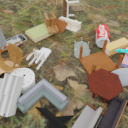
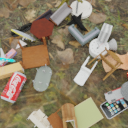
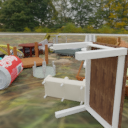
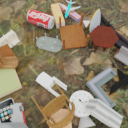
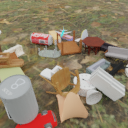
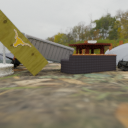
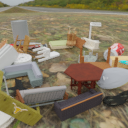
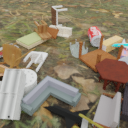
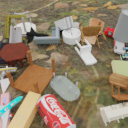
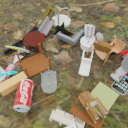

In [ ]:
rgb = ex['color_image']
rgb

array([[[[19.469809 ],
         [19.425415 ],
         [19.381636 ],
         ...,
         [19.381636 ],
         [19.425415 ],
         [19.469807 ]],

        [[19.21633  ],
         [19.17232  ],
         [19.128906 ],
         ...,
         [19.128906 ],
         [19.172318 ],
         [19.21633  ]],

        [[18.968842 ],
         [18.925198 ],
         [18.88215  ],
         ...,
         [18.882153 ],
         [18.9252   ],
         [18.968842 ]],

        ...,

        [[ 8.212199 ],
         [ 8.193305 ],
         [ 8.174668 ],
         ...,
         [ 8.174668 ],
         [ 8.193305 ],
         [ 8.212199 ]],

        [[ 8.192978 ],
         [ 8.174213 ],
         [ 8.1557045],
         ...,
         [ 8.1557045],
         [ 8.174213 ],
         [ 8.192978 ]],

        [[ 8.174188 ],
         [ 8.155551 ],
         [ 8.137169 ],
         ...,
         [ 8.137169 ],
         [ 8.155551 ],
         [ 8.174188 ]]],


       [[[15.955486 ],
         [15.919109 ],
         [15.883229 ],
         ...,
         [15.883229 ],
         [15.919107 ],
         [15.955487 ]],

        [[15.861035 ],
         [15.824709 ],
         [15.7888775],
         ...,
         [15.7888775],
         [15.824709 ],
         [15.861035 ]],

        [[15.767765 ],
         [15.731489 ],
         [15.695706 ],
         ...,
         [15.695705 ],
         [15.731488 ],
         [15.767765 ]],

        ...,

        [[10.896279 ],
         [10.87121  ],
         [10.846483 ],
         ...,
         [10.846483 ],
         [10.87121  ],
         [10.896279 ]],

        [[10.893531 ],
         [10.868583 ],
         [10.843972 ],
         ...,
         [10.843973 ],
         [10.868582 ],
         [10.893531 ]],

        [[10.891137 ],
         [10.866305 ],
         [10.841814 ],
         ...,
         [10.841814 ],
         [10.866305 ],
         [10.891137 ]]],


       [[[47.387787 ],
         [47.409256 ],
         [47.428772 ],
         ...,
         [47.42952  ],
         [47.40981  ],
         [47.38668  ]],

        [[47.407856 ],
         [47.429745 ],
         [47.44913  ],
         ...,
         [47.44998  ],
         [47.429844 ],
         [47.406845 ]],

        [[47.42952  ],
         [47.451847 ],
         [47.471096 ],
         ...,
         [47.472042 ],
         [47.45149  ],
         [47.428608 ]],

        ...,

        [[ 4.103538 ],
         [ 4.0940967],
         [ 4.0847845],
         ...,
         [ 4.0847845],
         [ 4.094097 ],
         [ 4.103538 ]],

        [[ 4.071757 ],
         [ 4.062431 ],
         [ 4.053233 ],
         ...,
         [ 4.053233 ],
         [ 4.0624313],
         [ 4.0717564]],

        [[ 4.0407305],
         [ 4.0315175],
         [ 4.0224304],
         ...,
         [ 4.0224314],
         [ 4.0315175],
         [ 4.0407305]]],


       ...,


       [[[27.929861 ],
         [27.866186 ],
         [27.803381 ],
         ...,
         [27.803381 ],
         [27.866188 ],
         [27.929863 ]],

        [[27.187534 ],
         [27.125267 ],
         [27.063848 ],
         ...,
         [27.06385  ],
         [27.125267 ],
         [27.187534 ]],

        [[26.481335 ],
         [26.420406 ],
         [26.360313 ],
         ...,
         [26.360315 ],
         [26.420406 ],
         [26.48133  ]],

        ...,

        [[ 6.7480154],
         [ 6.732491 ],
         [ 6.717177 ],
         ...,
         [ 6.7171774],
         [ 6.732491 ],
         [ 6.748016 ]],

        [[ 6.7225313],
         [ 6.7071357],
         [ 6.691948 ],
         ...,
         [ 6.691948 ],
         [ 6.707135 ],
         [ 6.7225313]],

        [[ 6.697562 ],
         [ 6.6822915],
         [ 6.6672306],
         ...,
         [ 6.6672306],
         [ 6.6822915],
         [ 6.697562 ]]],


       [[[21.382977 ],
         [21.334227 ],
         [21.286139 ],
         ...,
         [21.286139 ],
         [21.334225 ],
         [21.382977 ]],

        [[21.035112 ],
         [20.986937 ],
         [20.939419 ],
   
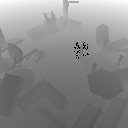
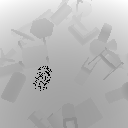
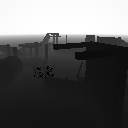
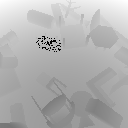
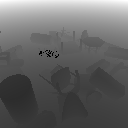
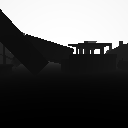
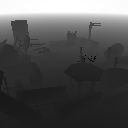
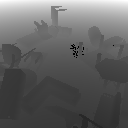
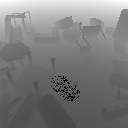
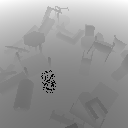

In [ ]:
# The original Kubric dataset has bug with infinit depth values, so manually clip values
depth = np.array(ex['depth_image'])
depth[depth > 100] = 0
depth

In [ ]:
rays = v3d.Ray(
    pos=ex['ray_origins'],
    dir=ex['ray_directions'],
)
rays.fig

Note that in the above plot, we try to display `10*128*128 == 163_840` rays. `v3d` dynamically & deterministically sub-samples rays to keep rendering time reasonable.

With the ray and depth, we can project the point cloud to the scene:

We could directly plot the `(..., 3)` `np.ndarray`, but we can also use `v3d.Point3d` to store color along the point cloud. Both rays & images have the same batch shape `(num_cam, h, w, ...)`, so no transformation required.

In [ ]:
point_cloud = v3d.Point3d(
    p=rays.scale_dir(depth).end,  # Project depth
    rgb=ex['color_image'],
)
point_cloud.fig

### Rendering & vectorization

Let's visualize everything together: The point cloud, the original camera, the camera trajectory:

In [ ]:
print(f'point_cloud.shape={point_cloud.shape}')
print(f'rays.shape={rays.shape}')
print(f'cams.shape={cams.shape}')

point_cloud, rays, cams

point_cloud.shape=(10, 128, 128)
rays.shape=(10, 128, 128)
cams.shape=(100,)


(Point3d(
     p=array([[[[-1.24416428e+01,  6.01863861e-01,  1.04351044e-02],
              [-1.23673248e+01,  6.92312241e-01,  1.04308128e-02],
              [-1.22930183e+01,  7.82756329e-01,  1.04317665e-02],
              ...,
              [-3.15281391e+00,  1.19075928e+01,  1.04327202e-02],
              [-3.07849884e+00,  1.19980354e+01,  1.04322433e-02],
              [-3.00419426e+00,  1.20884857e+01,  1.04365349e-02]],
 
             [[-1.21872196e+01,  4.96382713e-01,  1.04346275e-02],
              [-1.21137123e+01,  5.85851192e-01,  1.04346275e-02],
              [-1.20401974e+01,  6.75324917e-01,  1.04308128e-02],
              ...,
              [-2.99837303e+00,  1.16804180e+01,  1.04322433e-02],
              [-2.92485905e+00,  1.17698917e+01,  1.04327202e-02],
              [-2.85135269e+00,  1.18593636e+01,  1.04360580e-02]],
 
             [[-1.19382153e+01,  3.93143654e-01,  1.04346275e-02],
              [-1.18654842e+01,  4.81660366e-01,  1.04336739e-02],
              [-1.17927570e+01,  5.70180893e-01,  1.04341507e-02],
              ...,
              [-2.84721947e+00,  1.14580841e+01,  1.04346275e-02],
              [-2.77449656e+00,  1.15465984e+01,  1.04331970e-02],
              [-2.70176649e+00,  1.16351223e+01,  1.04341507e-02]],
 
             ...,
 
             [[ 1.18010163e+00, -5.04576874e+00,  1.04565620e-02],
              [ 1.21158671e+00, -5.00744677e+00,  1.04575157e-02],
              [ 1.24307466e+00, -4.96912384e+00,  1.04570389e-02],
              ...,
              [ 5.11587572e+00, -2.55414009e-01,  1.04570389e-02],
              [ 5.14736223e+00, -2.17089415e-01,  1.04575157e-02],
              [ 5.17884731e+00, -1.78766489e-01,  1.04570389e-02]],
 
             [[ 1.22606444e+00, -5.06482458e+00,  1.04556084e-02],
              [ 1.25740647e+00, -5.02667809e+00,  1.04560852e-02],
              [ 1.28874683e+00, -4.98852873e+00,  1.04570389e-02],
              ...,
              [ 5.14377308e+00, -2.96453714e-01,  1.04565620e-02],
              [ 5.17511654e+00, -2.58305311e-01,  1.04570389e-02],
              [ 5.20645809e+00, -2.20158577e-01,  1.04570389e-02]],
 
             [[ 1.27160335e+00, -5.08370686e+00,  1.04579926e-02],
              [ 1.30280304e+00, -5.04573345e+00,  1.04565620e-02],
              [ 1.33400011e+00, -5.00776100e+00,  1.04579926e-02],
              ...,
              [ 5.17141962e+00, -3.37115765e-01,  1.04570389e-02],
              [ 5.20261717e+00, -2.99143314e-01,  1.04565620e-02],
              [ 5.23381615e+00, -2.61170864e-01,  1.04570389e-02]]],
 
 
            [[[ 8.71494961e+00,  2.15003467e+00,  1.04494095e-02],
              [ 8.66862869e+00,  2.06603336e+00,  1.04589462e-02],
              [ 8.62230206e+00,  1.98203075e+00,  1.04579926e-02],
              ...,
              [ 2.92399383e+00, -8.35001755e+00,  1.04579926e-02],
              [ 2.87766385e+00, -8.43401527e+00,  1.04579926e-02],
              [ 2.83133388e+00, -8.51801205e+00,  1.04503632e-02]],
 
             [[ 8.59250164e+00,  2.19218779e+00,  1.04532242e-02],
              [ 8.54634190e+00,  2.10849452e+00,  1.04513168e-02],
              [ 8.50018406e+00,  2.02479959e+00,  1.04503632e-02],
              ...,
              [ 2.82266402e+00, -8.26955223e+00,  1.04513168e-02],
              [ 2.77650762e+00, -8.35324574e+00,  1.04513168e-02],
              [ 2.73034978e+00, -8.43694019e+00,  1.04532242e-02]],
 
             [[ 8.47094631e+00,  2.23403764e+00,  1.04551315e-02],
              [ 8.42495346e+00,  2.15064692e+00,  1.04541779e-02],
              [ 8.37896442e+00,  2.06725812e+00,  1.04570389e-02],
              ...,
              [ 2.72207952e+00, -8.18967915e+00,  1.04560852e-02],
              [ 2.67609000e+00, -8.27306843e+00,  1.04560852e-02],
              [ 2.63009667e+00, -8.35646057e+00,  1.04560852e-02]],
 
             ...,
 
             [[-1.82396173e+00,  5.77826595e+00,  1.04608536e-02],
              [-1.85574353e+00,  5.72063828e+00,  1.04598999e-

We can now render our trajectory by projecting the point cloud back to the cameras:

In [ ]:
imgs = cams.render(point_cloud[None, ...])
imgs

array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [209, 208, 204],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [135, 135,  88]],

        [[  0,   0,   0],
         [208, 207, 203],
         [208, 207, 202],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]]],


       [[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [114, 115,  39],
         [130, 123,  40],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [173, 168, 155],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [178, 172, 160],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [103,  95,  81],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [185, 181, 171],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]]],


       [[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [113, 100,  34],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [126, 119,  94],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]]],


       ...,


       [[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[131, 119,  44],
         [  0,   0,   0],
         [127, 115,  40],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [128, 116,  41],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   

A few explaination on what happened here: Because the 100 cameras are batched together, we only need a single call to render the 100 frames.

`v3d` support vectorization, which mean calling a function on a batched object is similar to wrapping it inside `jax.vmap`.

Here our cameras have shape `cams.shape == (100,)`, so we need to call `cams.render` on a `point_cloud.shape == (100, ...)`. `v3d` auto-broadcast dim of shape `1`, so `point_cloud[None, ...]` create `point_cloud.shape == (1, ...)` which is then broadcasted (so each camera render the frame on the full point cloud).

* `() @ (...,) -> (H, W)`
* `(100,) @ (100, ...) -> (100, H, W)`
* `(100,) @ (1, ,...) -> (100, H, W)`

More info on vectorization in the [recipes tutorial]().


## Customizing the plots (rename, subsampling,...)

Figure can be customized. Options can be set:

* Globally for all figures (`v3d.fig_config`):


In [ ]:
v3d.fig_config.show_zero = False

* At the individual figure level (`v3d.make_fig()`):

In [ ]:
fig = v3d.make_fig(cams, show_zero=False)

* At the object level (`.replace_fig_config(`):

In [ ]:
rays = rays.replace_fig_config(name='My rays', num_samples=None)

Global options (see [code](https://github.com/google-research/visu3d/tree/main/visu3d/plotly/fig_config_utils.py)):

* `show_zero`: Whether to always show the `(0, 0, 0)` origin
* `num_samples_xxx` (with `_xxx` to be `_ray`, `_point3d`,...). Globally control the subsampling for the matching class (`v3d.Ray`, `v3d.Point3d`,...).
* `cam_scale`: Factor to scale up/down of the cameras

Local options:

* `name`: Object name (default to `Ray`, `Camera`,...)
* `num_samples`: When too many objects are displayed at once, they will be dynamically subsampled to this value (`None` to disabling)
* (for cameras) `scale`: Factor to scale up/down of the cameras

## What's next

If you're ready to go to the next level, you can switch to the
* [Dataclass array tutorial](dataclass.ipynb): To create your custom dataclass with vectorization support.
* [Transformation tutorial](transform.ipynb): To learn about projections (e.g. 3d world -> 3d camera -> 2d pixel coordinates)